In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
from utilities_ketamine_analysis_v8 import *
from utils_signal_processing import *

In [ ]:
# You may need to uncomment the following line if running this
# notebook on Colab

# import ghostipy as gsp
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import os
import h5py
import warnings
import copy
from scipy.stats import zscore
from urllib.request import urlopen
plt.rcParams['pdf.fonttype'] = 42

import mne
import sys
import pickle

In [3]:
binFullPath = r'C:\Users\fentonlab\Desktop\Gino\LFPs'
HPC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','HPC_lfp_paths.file')
PFC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','PFC_lfp_paths.file')

rec = [{"PFC":"path","HPC":"path"} for _ in range(36)] # initialize dictonary for all the paths

# load HPC file names and store them in rec
with open(HPC_path_file,'rb') as f:
    HPC_file_list = pickle.load(f)
    
for ch, path in enumerate(HPC_file_list):
    rec[ch]['HPC'] =  str(path)

# load PFC file names and store them in rec 
with open(PFC_path_file,'rb') as f:
    PFC_file_list = pickle.load(f)
    
for ch, path in enumerate(PFC_file_list):
    rec[ch]['PFC'] =  str(path)

NameError: name 'os' is not defined

#### Load LFP data for a specific session, fs = 2500 Hz

In [4]:
sess = 2 # session/day

binFullPath = rec[sess]['HPC'] 
# print(binFullPath)
numChannels = 385

rawDataLfp = np.memmap(binFullPath, dtype='int16', mode='r')
dataLfp = np.reshape(rawDataLfp, (int(rawDataLfp.size/numChannels), numChannels))

# del rawDataLfp
# rawDataLfp._mmap.close()

NameError: name 'rec' is not defined

In [171]:
### Load gain correction factor for Lfp
meta = readMeta(Path(binFullPath))

# 3A, 3B1, 3B2 (NP 1.0)
imroList = meta['imroTbl'].split(sep=')')[1:-1]
LFgain = np.array([int(i.split(sep=' ')[4]) for i in imroList])
fI2V = Int2Volts(meta)
conv = fI2V/LFgain
gain = np.append(conv, 1) # scaling factor for Lfp

### Check if gain_correct is always the same 
if np.unique(gain[0:-1]):
    print(f'Gain factors all the same for each Lfp channel: {gain[0]} in Volts')
    gain = gain[0] 
else:
    print('Gain factor multiplication should be done channel by channel, this is just a bit slower')

Gain factors all the same for each Lfp channel: 9.375e-06 in Volts


#### Read LFP start/end time, HPC channels - Choose whether loading HPC or PFC here

In [172]:
pd.set_option('display.max_colwidth',100)
in_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs\\', "lfp_aln_idx.csv")
Lfp_aln = pd.read_csv(in_file)

In [173]:
Lfp_aln.head()

,Lfp start,Lfp end,HPC ch start,HPC ch end,Name_file
0,24077,18029080,225,348,2022-07-27_07-41-00_M015_SAL_PFC_HPC_0_0_0mpk_HPCprobe
1,56145,18614969,225,324,2022-07-28_13-19-00_M016_SAL_PFC_HPC_0_0_0mpk_HPCprobe
2,87594,18093008,205,300,2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe
3,62372,18064301,225,296,2022-08-03_12-45-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe
4,58586,18068529,165,304,2022-08-04_03-45-00_M016_RSK_mPFC_HPC_3_10_30mpk_HPCprobe


#### Pull Lfp 'start' and 'end' for the specific recording 

In [174]:
start = Lfp_aln["Lfp start"][sess] # starting of the trial in Lfp data points
end = Lfp_aln["Lfp end"][sess] # end of trial
# ch_start = Lfp_aln["HPC ch start"][sess]  # Hpc first channel
# ch_end = Lfp_aln["HPC ch end"][sess]  # Hpc last channel

In [175]:
dataLfp.shape

(18189064, 385)

In [176]:
# 0-120 CA1
# 0-86 ripples 
# 126-244 dentate

In [177]:
ch_start = 0
ch_end = 120
# Trim Lfp to specific channels in the HPC and to specific start/end times 
Lfp= dataLfp[start:end,ch_start:ch_end]
# Lfp = dataLfp[start:end,:]
Lfp.shape

(18005414, 120)

In [178]:
# time length in minutes
(end-start)/2500/60

120.03609333333334

### Load Speed, x, and y

In [179]:
speed_path = r'C:\Users\fentonlab\Desktop\Gino\speed\\'
x = np.load(os.path.join(speed_path, "x_aln.npy"), allow_pickle=True)
y = np.load(os.path.join(speed_path, "y_aln.npy"), allow_pickle=True)
speed = np.load(os.path.join(speed_path, "speed_aln.npy"), allow_pickle=True)

#### difference in time alignment between behavior and Lfp

In [180]:
print('Length in minutes of speed recordings: ',(speed[sess].size)/100/60)
print('Length in minutes of Lfp recordings: ',(Lfp.shape[0])/2500/60)
print('Difference in seconds: ',((Lfp.shape[0])/2500/60 - (speed[sess].size)/100/60)*60)

Length in minutes of speed recordings:  120.03833333333334
Length in minutes of Lfp recordings:  120.03609333333334
Difference in seconds:  -0.13440000000002783


#### Upsample Speed recording

In [181]:
speed_up = upsample_speed(speed, Lfp, sess, LFP_rate = 2500, speed_rate = 100)

# check if upsample done correctly
if (speed_up.size - Lfp.shape[0]) !=0:
    sys.exit("Speed upsampled size and Lfp size are not the same!")
speed_up.shape, Lfp.shape

((18005414,), (18005414, 120))

### Plot speed in a given session

Number of seconds:  3992.0


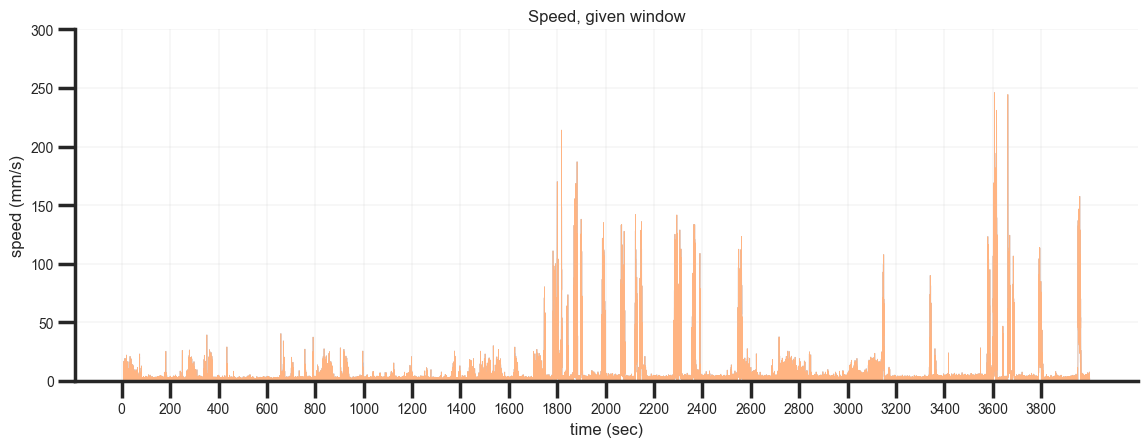

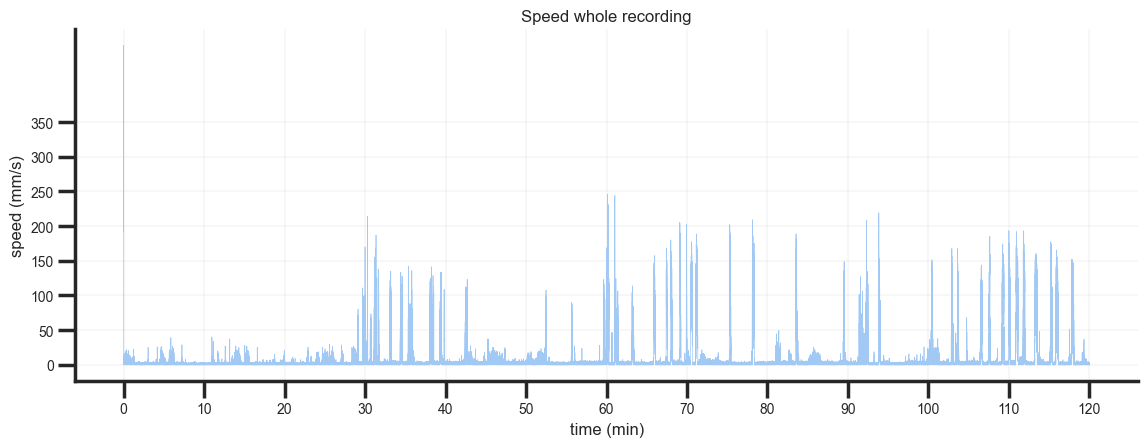

In [183]:
InteractiveShell.ast_node_interactivity = "last"
sampling = 2500
SRdiff = int(2500/100) # sample rate difference among Lfp and behavior
speed_T = np.linspace(0,speed[sess].size*SRdiff,speed[sess].size) # t axis for speed
speed_T_up = np.linspace(0,speed_up.size,speed_up.size) # t axis for speed

X = 200 # interval for xticks
s = 20000 # star
e = 10000000 # end

print('Number of seconds: ',(e-s)/sampling)

plt.figure(figsize=(12,5))

plt.plot(speed_T_up[s:e],speed_up[s:e],linewidth=0.5) # upsampled signal 
plt.plot(speed_T[int(s/SRdiff):int(e/SRdiff)],speed[sess][int(s/SRdiff):int(e/SRdiff)],linewidth=0.5) # original signal in line
# plt.plot(speed_T[int(s/SRdiff):int(e/SRdiff)],speed[sess][int(s/SRdiff):int(e/SRdiff)],'.r',markersize=5,linestyle='none',linewidth=0.5) # original signal in dots

plt.title('Speed, given window',fontsize=12)
plt.xlabel('time (sec)',fontsize=12)
plt.ylabel('speed (mm/s)',fontsize=12)

xticks = np.arange(0,e-s, step=X*sampling)
yticks = np.arange(0,400,50)
plt.xticks(ticks=xticks, labels=[str(int(i/sampling)) for i in xticks],fontsize=10)
plt.yticks(ticks=yticks,fontsize=10)
plt.grid(True,linewidth=0.2)
plt.ylim([0,300])
         
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(speed_up[:],linewidth=0.5) # upsampled signal 
plt.title('Speed whole recording',fontsize=12)
plt.xlabel('time (min)',fontsize=12)
plt.ylabel('speed (mm/s)',fontsize=12)
xticks = np.arange(0,speed_up.size, step=10*60*2500) # every 10 min
plt.xticks(ticks=xticks, labels=[str(int(i/60/2500)) for i in xticks],fontsize=10)
plt.yticks(ticks=yticks,fontsize=10)
plt.grid(True,linewidth=0.2)
# plt.ylim([0,100])

plt.tight_layout()
plt.show()

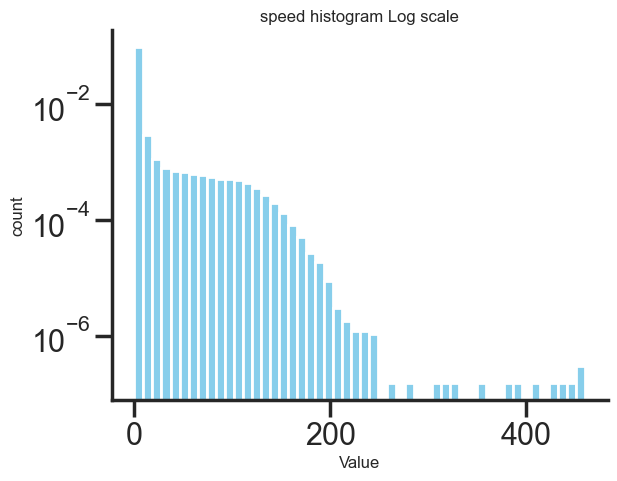

In [184]:
InteractiveShell.ast_node_interactivity = "last"
plt.hist(speed[sess], bins=50, edgecolor = 'white', color= 'skyblue',density=True)
plt.yscale('log')
plt.xscale('linear')
plt.title('speed histogram Log scale',fontsize=12)
plt.xlabel('Value',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.show()

### bin speed count based on value for histogram

In [22]:
th_low = 50
th_mid = 100
low = np.sum(speed_up < th_low)
mid = np.sum((speed_up >= th_low) & (speed_up <th_mid))
high = np.sum(speed_up >=th_mid)
speed_count = [low,mid,high]
speed_count

[17135927, 514634, 354853]

<Figure size 400x400 with 0 Axes>

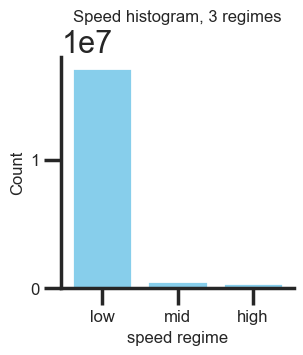

In [185]:
plt.figure(figsize=(4,4))
bin_edges = [0, 1, 2, 3]  
bins = range(len(speed_count))

plt.figure(figsize = (3,3))
# Plot bars
plt.bar(bins, speed_count, edgecolor='white', color='skyblue', align='center')

plt.title('Speed histogram, 3 regimes',fontsize=12)
plt.xlabel('speed regime',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.xticks(ticks=bins, labels=["low","mid","high"],fontsize=12)
plt.yticks(fontsize=12)

plt.show()

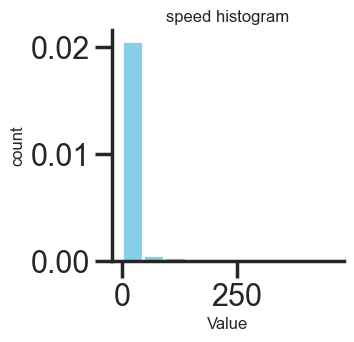

Histogram values (n): (array([2.06053682e-02, 5.89959009e-04, 4.10508497e-04, 9.76382010e-05,
       6.66194579e-06, 4.82312817e-07, 9.04336532e-08, 6.02891022e-08,
       9.04336532e-08, 1.50722755e-07]), array([7.81179367e-04, 4.60603610e+01, 9.21199409e+01, 1.38179521e+02,
       1.84239101e+02, 2.30298680e+02, 2.76358260e+02, 3.22417840e+02,
       3.68477420e+02, 4.14537000e+02, 4.60596580e+02]), <BarContainer object of 10 artists>)


In [186]:
plt.figure(figsize=(3,3))
n= plt.hist(speed[sess], bins=10, edgecolor = 'white', color= 'skyblue',density=True);
plt.title('speed histogram',fontsize=12)
plt.xlabel('Value',fontsize=12)
plt.ylabel('count',fontsize=12)

plt.show()

# Display histogram values
print("Histogram values (n):", n)
# print("Bin edges:", bins)

### LFP: Plot two channels

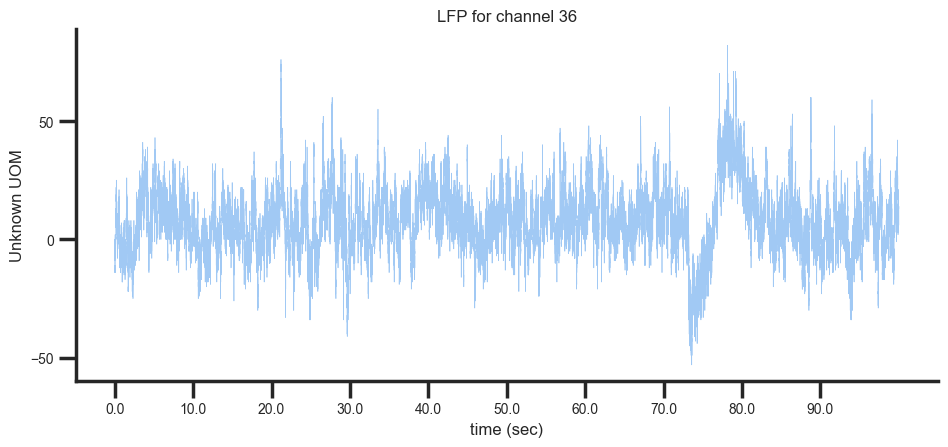

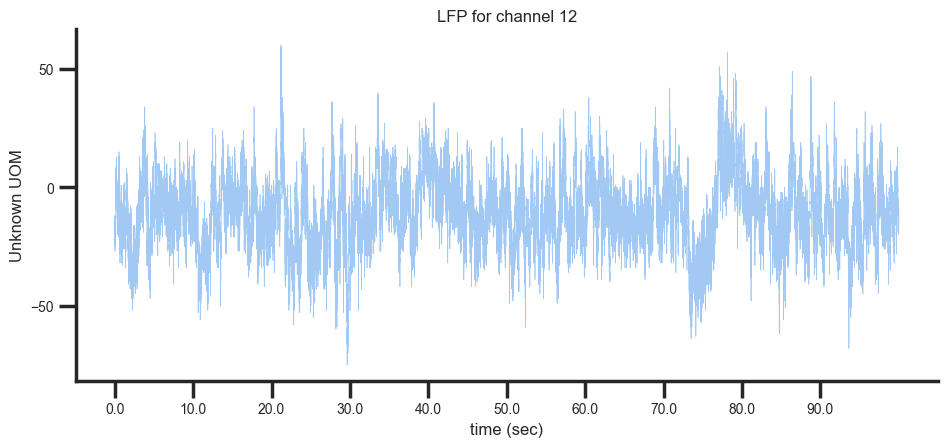

In [187]:
N = 2500  # sampling rate 
L_start = 0*N # start of time series in sec
L_end = 100*N # end of time series 
T = 10*N # xtick period 


ch = 36
plt.figure(figsize=(10,5))
plt.plot(Lfp[L_start:L_end,ch],linewidth=0.5)
plt.title(f'LFP for channel {ch}',fontsize=12)
plt.xlabel('time (sec)',fontsize=12)
plt.ylabel('Unknown UOM',fontsize=12)


xticks = np.arange(0,L_end-L_start, step=T)
plt.xticks(ticks=xticks, labels=[str(i/N) for i in xticks],fontsize=10)
plt.yticks(fontsize=10)
# print(xticks)
plt.tight_layout()
plt.show()


ch = 12
plt.figure(figsize=(10,5))
plt.plot(Lfp[L_start:L_end,ch],linewidth=0.5)
plt.title(f'LFP for channel {ch}',fontsize=12)
plt.xlabel('time (sec)',fontsize=12)
plt.ylabel('Unknown UOM',fontsize=12)


xticks = np.arange(0,L_end-L_start, step=T)
plt.xticks(ticks=xticks, labels=[str(i/N) for i in xticks],fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

### Plot various channels together

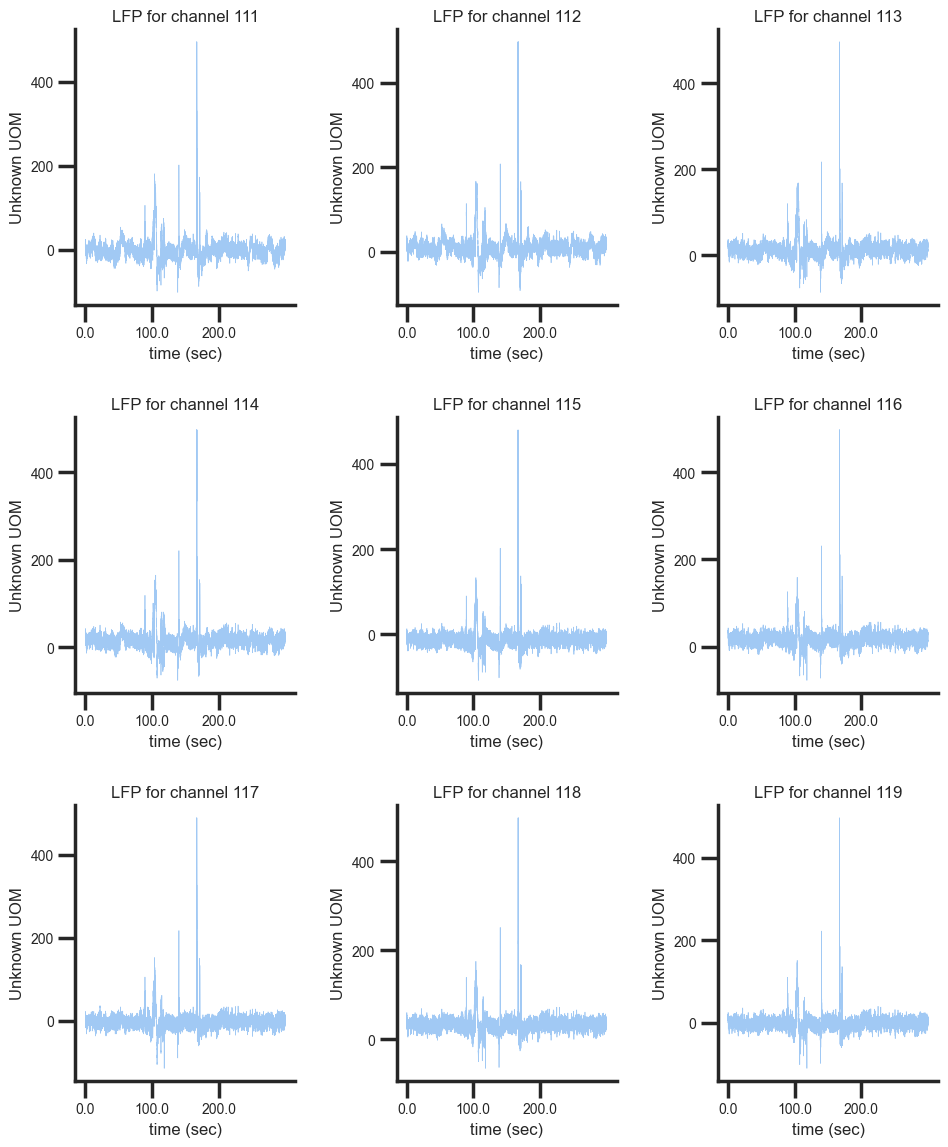

In [188]:
N = 2500  # sampling rate 
L_start = 1700*N # start of time series in sec
L_end = 2000*N # end of time series 
T = 100*N # xtick period 

P = 3 # rows
Q = 3 # colums

ch_a = 111 
ch_b = 120

# uncomment for zscore spectrogram 
# zlfp = zscore(Lfp[L_start:L_end,:],axis=0)
# lfp_plot = zlfp

lfp_plot = Lfp[L_start:L_end,:]

plt.figure(figsize=(10,12))
i = 1
for ch in range(ch_a,ch_b):
    
    plt.subplot(P,Q,i)
    i += 1   
    
    plt.plot(lfp_plot[:,ch],linewidth=0.5)
    plt.title(f'LFP for channel {ch}',fontsize=12)
    plt.xlabel('time (sec)',fontsize=12)
    plt.ylabel('Unknown UOM',fontsize=12)


    xticks = np.arange(0,L_end-L_start, step=T)
    plt.xticks(ticks=xticks, labels=[str(i/N) for i in xticks],fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


#### 2. Split speed and Lfp into injection periods (epochs): baseline, low, mid, and high injection

In [189]:
# cut Lfp and speed up to 2 h time window (disregard data above 2 h)
L = N*60*30*4 # time points in a 2 h time window
speed = speed_up[0:L]
lfp = Lfp[0:L,:]

speed_periods = speed.reshape(-1,int(speed.size/4))  # reshape speed in baseline, low, mid, high injection time periods

win_30 = N*60*30 # 30 min window 
Lfp_B = lfp[0:win_30,:]  # base line period
Lfp_L = lfp[win_30:2*win_30,:]  # low injection 
Lfp_M = lfp[2*win_30:3*win_30,:]  # mid injection 
Lfp_H = lfp[3*win_30:4*win_30,:]  # high injection 

speed_B = speed_periods[0,:]
speed_L = speed_periods[1,:]
speed_M = speed_periods[2,:]
speed_H = speed_periods[3,:]

print('min in each epoch: ',speed_B.size/N/60)
Lfp_B.shape, speed_B.shape

min in each epoch:  30.0


((4500000, 120), (4500000,))

#### Create list to store Lfp for each epoch: (channel, minute, n trial, trial data )

In [190]:
nch = lfp.shape[1]
lfp_B_epoch = [[] for ch in range(nch)]
lfp_L_epoch = [[] for ch in range(nch)]
lfp_M_epoch = [[] for ch in range(nch)]
lfp_H_epoch = [[] for ch in range(nch)]

#### ----- this can/should be included in a loop
#### 3. Select 1 min of data for each Epoch, for both Lfp and speed
##### Select 1 every M channels for the Lfp

In [191]:
InteractiveShell.ast_node_interactivity = "all"

# parameters
M = 1 # keep every M channel
current_min = 0 # minute to look at
length = 1 # length of period to look at, i.e. 1 = 1 min 
offset = 5 # starting of epoch in min

start = (offset + current_min)*60*N - 1    # start point in time points
end = (offset + current_min + length)*60*N - 1   # stop point in time points

# Lfp trim: 1 minute, one every M channel
Lfp_B_min = Lfp_B[start:end,::M]  # base line period
Lfp_L_min = Lfp_L[start:end,::M]  # low injection 
Lfp_M_min = Lfp_M[start:end,::M]  # mid injection 
Lfp_H_min = Lfp_H[start:end,::M]  # high injection 

# speed
speed_B_min = speed_B[start:end] 
speed_L_min = speed_L[start:end]
speed_M_min = speed_M[start:end]
speed_H_min = speed_H[start:end]


Lfp_B_min.shape, speed_B_min.shape, speed_B_min.size/N

((150000, 120), (150000,), 60.0)

#### 4. Filter Lfp in each epoch

In [192]:
# baseline
lfp_scaled_B = Lfp_B_min*gain*1e6 # scale in mV
lfp_filt_B = bandpass_filter(lfp_scaled_B, lowcut = 1, highcut = 300, fs=2500, order=5) # band pass filter at 1 Hz and 300 Hz
# low injection 
lfp_scaled_L = Lfp_L_min*gain*1e6 # scale in mV
lfp_filt_L = bandpass_filter(lfp_scaled_L, lowcut = 1, highcut = 300, fs=2500, order=5) # band pass filter at 1 Hz and 300 Hz
# mid injection 
lfp_scaled_M = Lfp_M_min*gain*1e6 # scale in mV
lfp_filt_M = bandpass_filter(lfp_scaled_M, lowcut = 1, highcut = 300, fs=2500, order=5) # band pass filter at 1 Hz and 300 Hz
# high injection 
lfp_scaled_H = Lfp_H_min*gain*1e6 # scale in mV
lfp_filt_H = bandpass_filter(lfp_scaled_H, lowcut = 1, highcut = 300, fs=2500, order=5) # band pass filter at 1 Hz and 300 Hz

lfp_filt_B.shape

(150000, 120)

In [66]:
# lfp_hp = highpass_filter(lfp_scaled_B, 0.5, fs=2500, order=5)
# lfp_filt_B2 = bandpass_filter(lfp_hp, 1, 500, fs=2500, order=5)
# lfp_filt_B = notch_filter(lfp_bp, 60, 2500)

#### Plot filtered and non-filtered Lfp

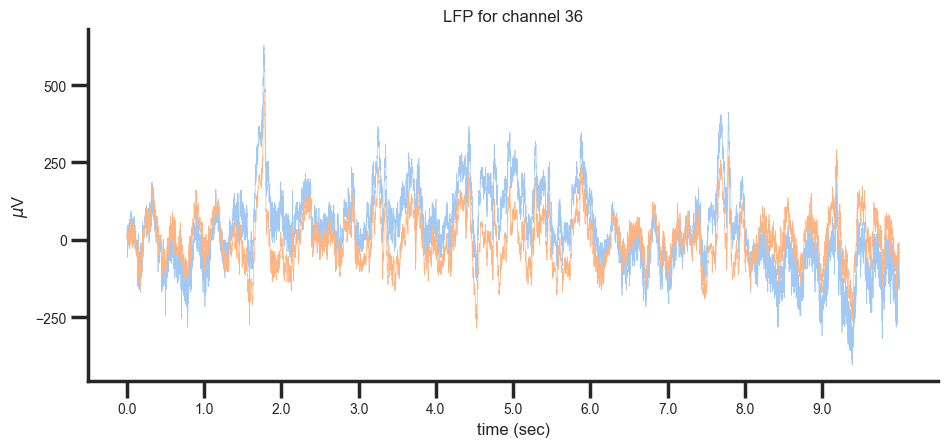

In [194]:
InteractiveShell.ast_node_interactivity = "last"

N = 2500  # sampling rate 
L_start = 0*N # start of time series in sec
L_end = 10*N # end of time series 
T = 1*N # xtick period 

lfp_scaled = lfp_scaled_M
lfp_filt = lfp_filt_M

ch = 36
plt.figure(figsize=(10,5))
plt.plot(lfp_scaled[L_start:L_end,ch],linewidth=0.5)
plt.plot(lfp_filt[L_start:L_end,ch],linewidth=0.5)
# plt.plot(lfp_filt_B2[L_start:L_end,ch],linewidth=0.5)
plt.title(f'LFP for channel {ch}',fontsize=12)
plt.xlabel('time (sec)',fontsize=12)
plt.ylabel('$\mu$V',fontsize=12)


xticks = np.arange(0,L_end-L_start, step=T)
plt.xticks(ticks=xticks, labels=[str(i/N) for i in xticks],fontsize=10)
plt.yticks(fontsize=10)
# print(xticks)
plt.tight_layout()
plt.show()

#### 5. Decimate Lfp and speed to 1250 Hz

In [195]:
# original sampling freq. 2500 Hz

# decimated Lfp to 1250 Hz
lfp_dec_B = lfp_filt_B[::2,:]
lfp_dec_L = lfp_filt_L[::2,:]
lfp_dec_M = lfp_filt_M[::2,:]
lfp_dec_H = lfp_filt_H[::2,:]

# decimated speed to 1250 Hz
speed_dec_B = speed_B_min[::2]
speed_dec_L = speed_L_min[::2]
speed_dec_M = speed_M_min[::2]
speed_dec_H = speed_H_min[::2]

# # decimated Lfp to 250 Hz
# lfp_dec_B_250 = lfp_filt_B[::10,:]
# lfp_dec_L_250 = lfp_filt_L[::10,:]
# lfp_dec_M_250 = lfp_filt_M[::10,:]
# lfp_dec_H_250 = lfp_filt_H[::10,:]

# # decimated speed to 250 Hz
# speed_dec_B_250 = speed_B_min[::10]
# speed_dec_L_250 = speed_L_min[::10]
# speed_dec_M_250 = speed_M_min[::10]
# speed_dec_H_250 = speed_H_min[::10]

lfp_dec_B.shape, speed_dec_B.shape, speed_dec_B.shape[0]/1250 #, lfp_dec_B_250.shape, speed_dec_B_250.shape, speed_dec_B_250.shape[0]/250

((75000, 120), (75000,), 60.0)

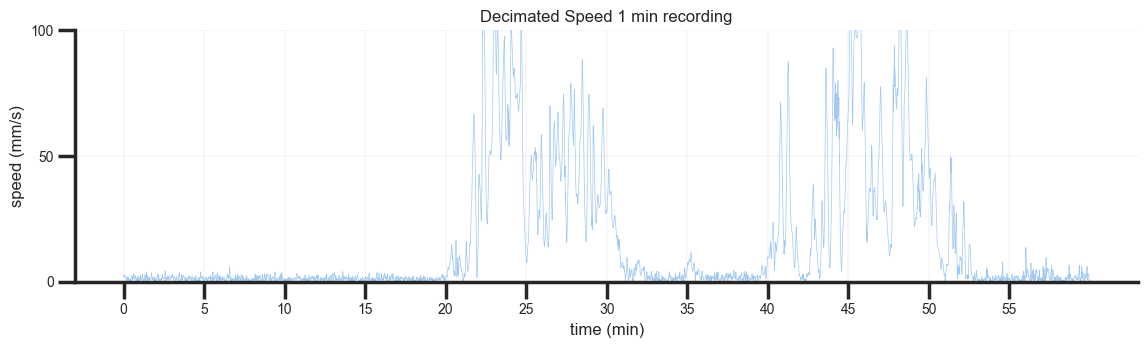

In [196]:
# check speed after decimation
InteractiveShell.ast_node_interactivity = "last"

speed = speed_dec_L

fs = 1250
plt.figure(figsize=(12,4))
plt.plot(speed,linewidth=0.5) # upsampled signal 
plt.title('Decimated Speed 1 min recording',fontsize=12)
plt.xlabel('time (min)',fontsize=12)
plt.ylabel('speed (mm/s)',fontsize=12)
xticks = np.arange(0,speed.size, step=5*fs) # every 10 min
plt.xticks(ticks=xticks, labels=[str(int(i/fs)) for i in xticks],fontsize=10)
plt.yticks(ticks=yticks,fontsize=10)
plt.grid(True,linewidth=0.2)
plt.ylim([0,100])

plt.tight_layout()
plt.show()

#### 6. Identify artifacts in 1 min Lfp (this can be improved)

#### 6.0 - Z-scored lfp for future reference

In [197]:
# Z-scored Lfp
zlfp_B = zscore(lfp_dec_B,axis=0)
zlfp_L = zscore(lfp_dec_L,axis=0)
zlfp_M = zscore(lfp_dec_M,axis=0)
zlfp_H = zscore(lfp_dec_H,axis=0)

#### 6.1 - Plot zscored Lfp for investigation of the artifacts

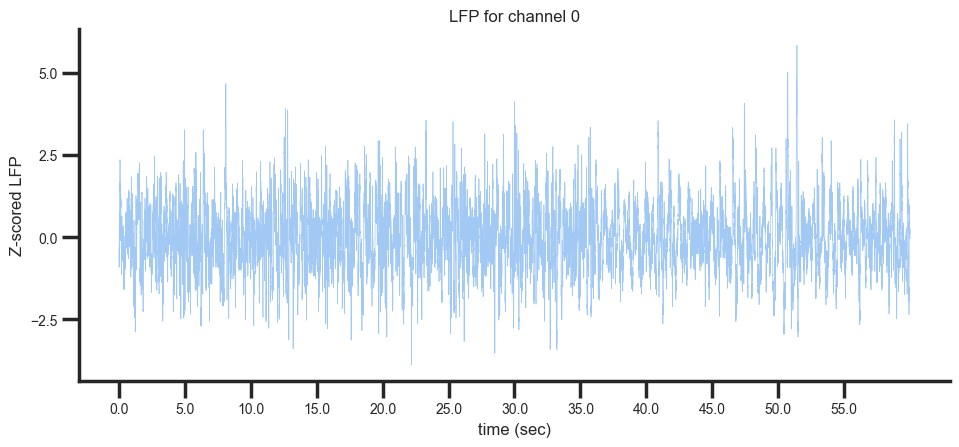

In [198]:
InteractiveShell.ast_node_interactivity = "last"

lfp_plot = zlfp_B

ch = 0
N = 1250  # sampling rate 
L_start = 0*N # start of time series in sec
L_end = 60*N # end of time series 
T = 5*N # xtick period 

plt.figure(figsize=(10,5))
plt.plot(lfp_plot[L_start:L_end,ch],linewidth=0.5)
plt.title(f'LFP for channel {ch}',fontsize=12)
plt.xlabel('time (sec)',fontsize=12)
plt.ylabel('Z-scored LFP',fontsize=12)

xticks = np.arange(0,L_end-L_start, step=T)
plt.xticks(ticks=xticks, labels=[str(i/N) for i in xticks],fontsize=10)
plt.yticks(fontsize=10)
# print(xticks)
plt.tight_layout()
plt.show()

#### 6.2 - Create masks for artifact trials in Lfp

In [199]:
mask_trial_B, lfp_mask_B, good_trial_rate_B = lfp_artifacts_mask(lfp_dec_B,1250,4)
mask_trial_L, lfp_mask_L, good_trial_rate_L = lfp_artifacts_mask(lfp_dec_L,1250,4)
mask_trial_M, lfp_mask_M, good_trial_rate_M = lfp_artifacts_mask(lfp_dec_M,1250,4)
mask_trial_H, lfp_mask_H, good_trial_rate_H = lfp_artifacts_mask(lfp_dec_H,1250,4)

In [200]:
cnt = np.sum(mask_trial_B,axis=0)
cnt , good_trial_rate_B

(array([55, 56, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 56, 56, 56, 56, 56,
        56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 56, 57,
        56, 57, 55, 57, 56, 56, 55, 55, 55, 55, 53, 55, 54, 55, 56, 56, 57,
        56, 59, 56, 57, 58, 60, 53, 55, 58, 59, 59, 56, 57, 59, 57, 59, 57,
        58, 55, 55, 57, 58, 58, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 56,
        58, 57, 58, 58, 57, 56, 57, 58, 58, 58, 58, 57, 55, 55, 56, 57, 56,
        57, 56, 55, 56, 58, 57, 57, 58, 57, 54, 55, 56, 56, 55, 55, 54, 53,
        54]),
 array([0.91666667, 0.93333333, 0.88333333, 0.88333333, 0.88333333,
        0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
        0.91666667, 0.91666667, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 0.95      , 0.95      , 0.95      , 0.95      ,
        0.95      , 0.95      , 0.93333333, 0.

##### Plot zscored Lfp and good/bad trial range

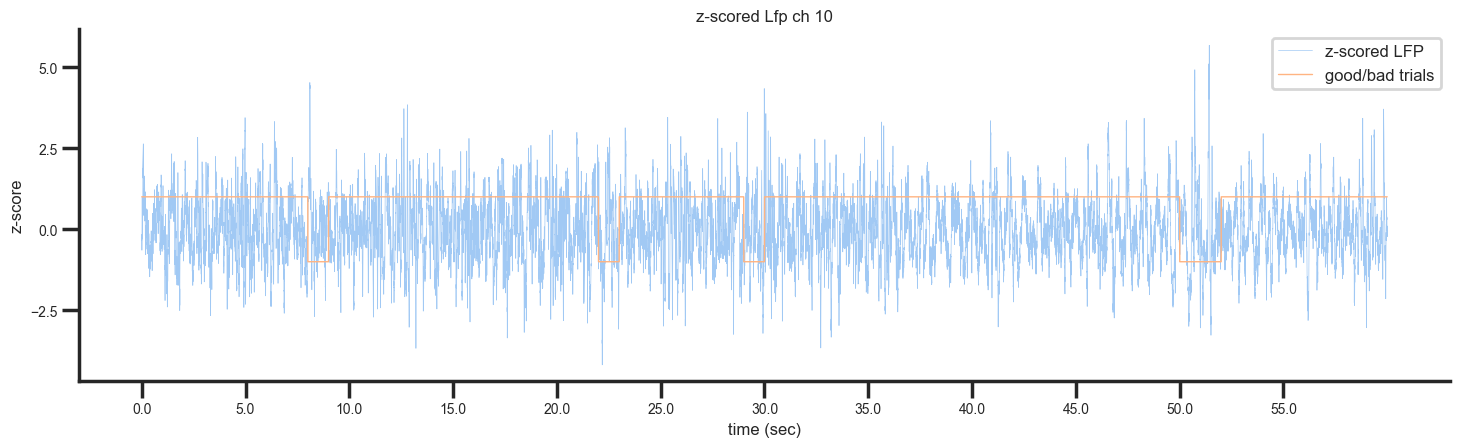

In [201]:
InteractiveShell.ast_node_interactivity = "last"

N = 1250  # sampling rate 
L_start = 0*N # start of time series in sec
L_end = 60*N # end of time series 
T = 5*N # xtick period 

lfp_plot = zlfp_B
lfp_mask = lfp_mask_B

ch = 10
plt.figure(figsize=(15,5))
plt.plot(lfp_plot[L_start:L_end,ch],linewidth=0.5)
plt.plot(lfp_mask[L_start:L_end,ch],linewidth=1)
# plt.plot(lfp_filt_B2[L_start:L_end,ch],linewidth=0.5)
plt.title(f'z-scored Lfp ch {ch}',fontsize=12)
plt.xlabel('time (sec)',fontsize=12)
plt.ylabel('z-score',fontsize=12)


xticks = np.arange(0,L_end-L_start, step=T)
plt.xticks(ticks=xticks, labels=[str(i/N) for i in xticks],fontsize=10)
plt.yticks(fontsize=10)
plt.legend(['z-scored LFP','good/bad trials'],fontsize=12)
# print(xticks)
plt.tight_layout()
plt.show()

#### 7. Create speed mask 

In [202]:
# make a speed map for low speed
win = 1250 # 1 sec mask
th = 50 # speed threshold 
speed_mask_B = create_speed_mask(speed_dec_B,win,th,'base')
speed_mask_L = create_speed_mask(speed_dec_L,win,th,'low')
speed_mask_M = create_speed_mask(speed_dec_M,win,th,'mid')
speed_mask_H = create_speed_mask(speed_dec_H,win,th,'high')
speed_mask_M

low speed trials % in base : 1.00
low speed trials % in low : 0.70
low speed trials % in mid : 0.85
low speed trials % in high : 1.00


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False])

#### 8. Combine speed mask with artifacts mask

In [86]:
# Combine the lfp good trial mask with the low speed mask
tot_mask_B = (mask_trial_B.T & speed_mask_B).T
tot_mask_L = (mask_trial_L.T & speed_mask_L).T
tot_mask_M = (mask_trial_M.T & speed_mask_M).T
tot_mask_H = (mask_trial_H.T & speed_mask_H).T

cnt = np.sum(mask_trial_M,axis=0)
cnt_tot = np.sum(tot_mask_M,axis=0)
cnt - cnt_tot # mask difference, must be >= 0

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 8, 9, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 8, 9, 8, 9, 6,
       9, 9, 9, 8, 7, 8, 9, 9, 8, 8, 8, 9, 8, 9, 9, 9, 8, 9, 8, 8, 8, 9,
       8, 7, 7, 8, 8, 9, 8, 8, 6, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7,
       7, 6, 7, 7, 7, 8, 8, 7, 7, 7])

In [93]:
tot_good_trial_rate_B = np.sum(np.sum(tot_mask_B,axis=0))/60/nch
tot_good_trial_rate_L = np.sum(np.sum(tot_mask_L,axis=0))/60/nch
tot_good_trial_rate_M = np.sum(np.sum(tot_mask_M,axis=0))/60/nch
tot_good_trial_rate_H = np.sum(np.sum(tot_mask_H,axis=0))/60/nch
print('good trial rate base = {:.2f}, low = {:.2f}, mid = {:.2f}., high = {:.2f}'.format(tot_good_trial_rate_B,tot_good_trial_rate_L,tot_good_trial_rate_M,tot_good_trial_rate_H))

good trial rate base = 0.94, low = 0.65, mid = 0.79., high = 0.96


In [94]:
# # reshape Lfp in trial x time window x channels
LfpRB = lfp_dec_B.reshape(int(lfp_dec_B.shape[0]/win),-1,lfp_dec_B.shape[1]) # reshape Lfp: trial x win length x channel
LfpRL = lfp_dec_L.reshape(int(lfp_dec_L.shape[0]/win),-1,lfp_dec_L.shape[1]) # reshape Lfp: trial x win length x channel
LfpRM = lfp_dec_M.reshape(int(lfp_dec_M.shape[0]/win),-1,lfp_dec_M.shape[1]) # reshape Lfp: trial x win length x channel
LfpRH = lfp_dec_H.reshape(int(lfp_dec_H.shape[0]/win),-1,lfp_dec_H.shape[1]) # reshape Lfp: trial x win length x channel

LfpRB.shape, LfpRL.shape, LfpRM.shape, LfpRH.shape

((60, 1250, 120), (60, 1250, 120), (60, 1250, 120), (60, 1250, 120))

In [95]:
# Keep only good trial in Lfp.
# ouput: list with nch, each element contains N-good-trial x time values, N-good-trial may differ channel by channel

lfp_B_list = [] 
lfp_L_list = []
lfp_M_list = []
lfp_H_list = []  

nch = lfp_dec_B.shape[1]
for ch in range(nch):
    good_trials = LfpRB[tot_mask_B[:,ch],:,ch] # good trials per each channel
    lfp_B_list.append(good_trials)
    good_trials = LfpRL[tot_mask_L[:,ch],:,ch] # good trials per each channel
    lfp_L_list.append(good_trials)
    good_trials = LfpRM[tot_mask_M[:,ch],:,ch] # good trials per each channel
    lfp_M_list.append(good_trials)
    good_trials = LfpRH[tot_mask_H[:,ch],:,ch] # good trials per each channel
    lfp_H_list.append(good_trials)

len(lfp_B_list), lfp_B_list[0].shape, lfp_L_list[0].shape, lfp_L_list[0].shape, lfp_L_list[0].shape

(120, (55, 1250), (34, 1250), (34, 1250), (34, 1250))

#### 9. Save 1 min LFP to be opened in matlab for signal processing
- 1 min only, all channels, filtered band pass at [1,300] Hz 
- Only trials with low speed (below 50 mm/sec)
- LFP subsampled at 1250 Hz
- Only trials with NO artifacts (abs(zscore) < 4), i.e. Lfp fluctuations below 4 std  
- Trial length = 1 sec

In [96]:
lfp_B_list[0].shape

(55, 1250)

#### Stack 1 min Lfp, for the whole epoch
Resulting list, lfp_E_epoch: channel, minute, (trial num x trial length).

In [112]:
for ch in range(nch):
    lfp_B_epoch[ch].append(lfp_B_list[ch]) # add one minute lfp: trial num x trial length, for each channel
    lfp_L_epoch[ch].append(lfp_L_list[ch])
    lfp_M_epoch[ch].append(lfp_M_list[ch])
    lfp_H_epoch[ch].append(lfp_H_list[ch])

In [113]:
lfp_B_epoch[0][1].shape

(55, 1250)

In [125]:
# file path to save in matlab 
out_file_B = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC\\', "lfp_B_epoch.mat")
out_file_L = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC\\', "lfp_L_epoch.mat")
out_file_M = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC\\', "lfp_M_epoch.mat")
out_file_H = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC\\', "lfp_H_epoch.mat")

# create dictionaries 
mat_lfp_B = {'lfp_B': lfp_B_epoch}
mat_lfp_L = {'lfp_L': lfp_L_epoch}
mat_lfp_M = {'lfp_M': lfp_M_epoch}
mat_lfp_H = {'lfp_H': lfp_H_epoch}

# save lfp for each epoch in matlab format 
savemat(out_file_B,mat_lfp_B)
savemat(out_file_L,mat_lfp_L)
savemat(out_file_M,mat_lfp_M)
savemat(out_file_H,mat_lfp_H)

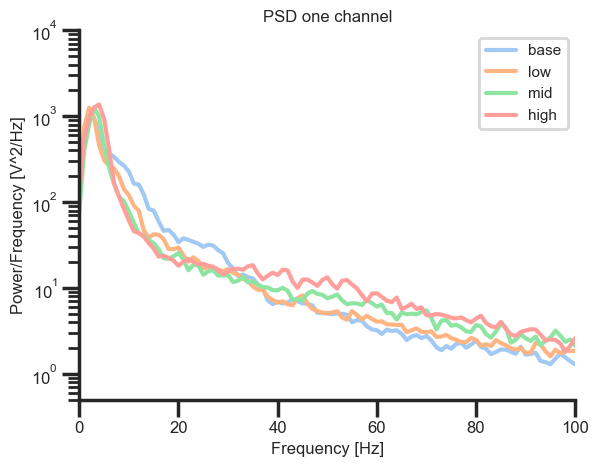

In [56]:
# Compute PSD using Welch's method
ch = 50
time = lfp_B_list[ch].reshape(-1)
freqs, psd_B = welch(time, fs=1250, nperseg=1250, noverlap = None,scaling='density')

time = lfp_L_list[ch].reshape(-1)
freqs, psd_L = welch(time, fs=1250, nperseg=1250, noverlap = None,scaling='density')

time = lfp_M_list[ch].reshape(-1)
freqs, psd_M = welch(time, fs=1250, nperseg=1250, noverlap = None,scaling='density')

time = lfp_H_list[ch].reshape(-1)
freqs, psd_H = welch(time, fs=1250, nperseg=1250, noverlap = None,scaling='density')

# freqs, psd_filt = welch(lfp_filt_B[:,10], fs=2500, nperseg=1024, scaling='density')

# Plot
plt.semilogy(freqs, psd_B)
plt.semilogy(freqs, psd_L)
plt.semilogy(freqs, psd_M)
plt.semilogy(freqs, psd_H)
# plt.semilogy(freqs, psd_filt)
plt.title('PSD one channel',fontsize=12)
plt.xlabel('Frequency [Hz]',fontsize=12)
plt.ylabel('Power/Frequency [V^2/Hz]',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['base',"low","mid","high"],fontsize=11)
plt.xlim([0,100])
plt.ylim([0.5,1e4])
plt.show()

In [467]:
import sys 
size = sys.getsizeof(lfp_B_list)
for arr in lfp_B_list:
    size += arr.nbytes
print(f"Size in megabytes (MB): {size / (1024**2):.2f}")

Size in megabytes (MB): 48.25


In [87]:
50*20

1000

In [70]:
50*20*4*36/1000

144.0

In [30]:
import pickle
with open(r'Z:\f\fentonlab\RAWDATA\NeuroPix\spk_ketamine\spk_500Hz_2.file','rb') as f:
    cell = pickle.load(f)
    

In [35]:
cell[0].shape, cell[0].shape[1]*10

((223, 1800499), 18004990)

In [34]:
Lfp.shape, dataLfp.shape

((18005414, 120), (18189064, 385))

In [37]:
(Lfp.shape[0] - cell[0].shape[1]*10)/2500/60

0.0028266666666666666